<a href="https://colab.research.google.com/github/NMashalov/2023_OpenMipt_course/blob/main/lesson12/%D0%94%D0%97_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Домашнее задание 12

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание:**

* Задача 1 &mdash; 60 баллов






-----

In [ ]:
# Bot check

# HW_ID: phds_hw12
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from statsmodels.stats.proportion import proportion_confint
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.datasets as smd
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

sns.set(palette='Set2', style='whitegrid', font_scale=1.3)

pd.options.mode.chained_assignment = None

In [2]:
alpha = 0.05
sample_size = 1_000
n_iter = 10_000

# Задача 1

Рассмотрим [данные по пациентам](https://www.kaggle.com/datasets/jillanisofttech/diabetes-disease-updated-dataset?select=diabetes.csv), страдающим диабетом.

Скачайте файл и оставьте колонки:
* `Age` &mdash; возраст;
* `BloodPressure` &mdash; диастолическое давление;
* `Insulin` &mdash; уровень инсулина;
* `Outcome` &mdash; целевая переменная;

Задача состоит в том, чтобы исследовать работоспособность различных видов A/B тестирования с использованием метода CUPED на распределении уровня инсулина (признак `Insulin`)

In [4]:
!pip install opendatasets

In [5]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/jillanisofttech/diabetes-disease-updated-dataset?select=diabetes.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mashalovne
Your Kaggle Key: ··········


100%|██████████| 8.91k/8.91k [00:00<00:00, 1.86MB/s]

In [6]:
DATA_PATH = '/content/diabetes-disease-updated-dataset/diabetes.csv'

In [7]:
data = pd.read_csv(DATA_PATH)

In [38]:
data = data[ ['Age','BloodPressure','Insulin','Outcome']]
data

,Age,BloodPressure,Insulin,Outcome
0,50,72,0,1
1,31,66,0,0
2,32,64,0,1
3,21,66,94,0
4,33,40,168,1
...,...,...,...,...
763,63,76,180,0
764,27,70,0,0
765,30,72,112,0
766,47,60,0,1


In [9]:
def draw_interval(
    real_alpha, left_alpha, right_alpha,
    alpha=0.05, figsize=(7, 2)
):
    '''
    Отрисовка интервала для реального уровня значимости
    real_alpha -- оценка уровня значимости
    left_alpha, right_alpha -- границы доверительного интервала
    alpha -- теоретический уровень значимости
    figsize -- размер фигуры matplotlib
    '''

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(6, 2))
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_alpha, right_alpha], [0.15]*2, [-0.15]*2,
            color='green', alpha=0.6
        )
        plt.scatter(real_alpha, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_alpha)-1e-3, max(alpha, right_alpha)+1e-3))
        plt.title(
            f'Доля отвержений = {100*real_alpha:.2f}%, '
            f'интервал ({100*left_alpha:.2f}%, {100*right_alpha:.2f}%)'
        )
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()

def calculate_real_alpha(n_errors, n_iter):
    '''
    Оценка реального уровня значимости и его дов. интервала.

    Аргументы:
    n_errors -- количество ошибок в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    real_alpha -- оценка реального уровня значимости
    left_alpha, right_alpha -- границы соотв. дов. интервала
    '''

    real_alpha = n_errors / n_iter
    left_alpha, right_alpha = proportion_confint(n_errors, n_iter, method='wilson')

    return real_alpha, left_alpha, right_alpha

In [36]:
def AA_test(
    test, x_data, y_data=None,
    n_iter=10000, sample_size=1000, effect=0, relative_effect=True, alpha=0.05
):
    '''
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    x_data, y_data -- данные, из которых будут семплирповаться выборки
    n_iter -- количество итераций
    sample_size -- размер выборок
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теоретический уровень значимости
    '''

    if y_data is None:
        y_data = x_data

    n_errors = 0  # количество отвержений H_0

    # Проведение экспериментов
    for _ in tqdm(range(n_iter)):
        # Генерируем выборки
        x_sample = x_data.sample(sample_size, replace=False)
        y_sample = y_data.sample(sample_size, replace=False)

        # Добавляем эффект, если хотим оценить мощность
        if relative_effect:
            x_sample *= 1 + effect
        else:
            x_sample += effect

        # Применяем критерий
        n_errors += test(x_sample, y_sample)

    # Реальный уровень значимости
    real_alpha, left_alpha, right_alpha = calculate_real_alpha(n_errors, n_iter)
    draw_interval(real_alpha, left_alpha, right_alpha, alpha=alpha)

##1. Обычный t-тест

Начнём с применения обычного t-теста. Оцените реальный уровень значимости критерия и его мощность на ваших данных

AA тест. Значимость


100%|██████████| 1000/1000 [00:01<00:00, 639.52it/s]


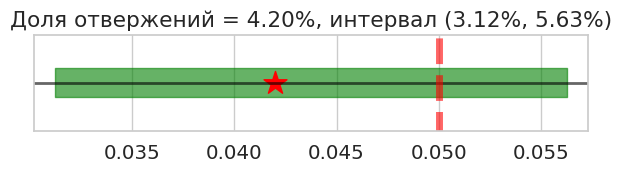

AB тест. Мощность


100%|██████████| 1000/1000 [00:02<00:00, 392.96it/s]


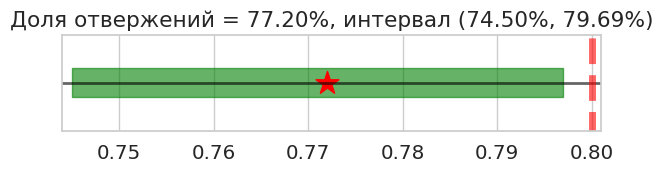

In [51]:
# Ваш код
print('AA тест. Значимость')
AA_test(
    test=lambda x,y: sps.ttest_ind(x,y)[1] < 0.05,
    x_data=data['Insulin'],
    n_iter = 1000,
    sample_size=100
);

print('AB тест. Мощность')
AA_test(
    test=lambda x,y: sps.ttest_ind(x,y)[1] < 0.05,
    x_data=data['Insulin'],
    n_iter = 1000,
    sample_size=400,
    effect = 0.3,
    alpha=0.8
);


Различие стат значимо

##2. Линейные модели на основе ковариат
Перейдём к использованию линейных моделей. Построим следующую модель:

$$
Y = \theta_0 + \theta_1 \cdot \text{type} + X^T\Theta
$$

где $X$ - это признаки, влияющие на целевую переменную.

Если будет иметься значимое отклонение значения параметра $\theta_1$, то можно считать, что среднее двух групп различается. Для проверки этого требуется критерий Стьюдента.

In [73]:
smf.ols('Insulin ~ Outcome + Age + BloodPressure',data=data).fit().cov_params().loc['Outcome','Outcome']

78.36157575583

In [77]:
def lin_ttest(x_data, y_data, condition):
    '''
    Абсолютный t-test.

    :param x_data: данные тестовой группы
    :param y_data: данные контрольной группы
    :param condition: формула, описывающая модель
    :return: статистика критерия, p-value
    '''

    # Обучите модель на объединённых данных
    assert 'Outcome' in condition, 'Outcome should be in condition'

    def calc_mean_and_var(x):
        model = smf.ols(condition,data=x).fit()
        return model.params['Outcome'], model.cov_params().loc['Outcome','Outcome']

    (m1_mean, m1_var),(m2_mean,m2_var) = calc_mean_and_var(x_data), calc_mean_and_var(y_data)

    t = (m1_mean - m2_mean) / np.sqrt(m1_var + m2_var)
    #print(t)

    # проверьте критерий Стьюдента
    return 2*sps.norm.sf(abs(t))< 0.05

Поэкспериментируйте с выбором ковариат. Проведите оценку реального уровня значимости и мощности критерия

Insulin ~ Outcome + Age + BloodPressure
AA тест. Значимость


100%|██████████| 1000/1000 [00:22<00:00, 44.56it/s]


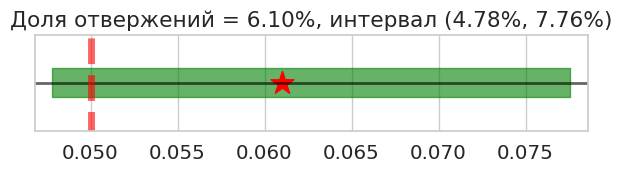

AB тест. Мощность


100%|██████████| 1000/1000 [00:22<00:00, 43.67it/s]


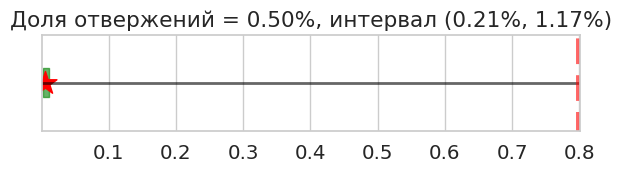

Insulin ~ Outcome + Age
AA тест. Значимость


100%|██████████| 1000/1000 [00:18<00:00, 53.18it/s]


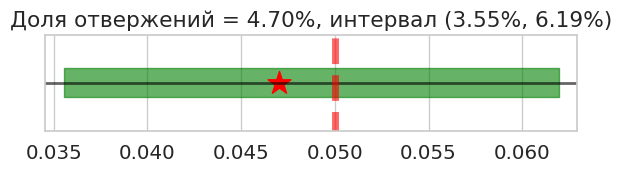

AB тест. Мощность


100%|██████████| 1000/1000 [00:19<00:00, 50.71it/s]


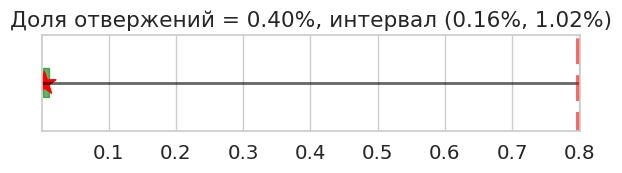

Insulin ~ Outcome + BloodPressure
AA тест. Значимость


100%|██████████| 1000/1000 [00:19<00:00, 52.45it/s]


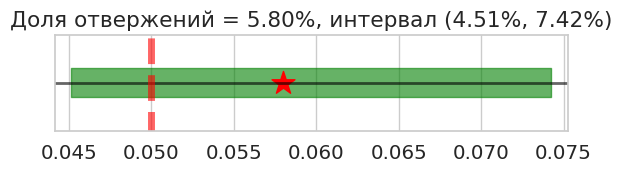

AB тест. Мощность


100%|██████████| 1000/1000 [00:20<00:00, 48.67it/s]


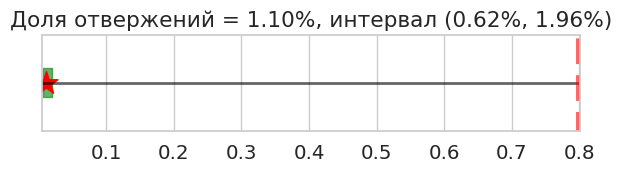

In [79]:
# ваш код
from functools import partial

formulas = ['Insulin ~ Outcome + Age + BloodPressure','Insulin ~ Outcome + Age','Insulin ~ Outcome + BloodPressure']



for f in formulas:
    print(f)
    test = partial(lin_ttest, condition=f)
    print('AA тест. Значимость')
    AA_test(
        test=test,
        x_data=data,
        n_iter = 1000,
        sample_size=100
    );

    print('AB тест. Мощность')

    AA_test(
        test=test,
        x_data=data,
        n_iter = 1000,
        sample_size=400,
        effect = 0.3,
        alpha=0.8
    );


##3. Создание признака с помощью сторонних моделей

В качестве ковариаты можно использовать предсказания модели машинного обучения для интересующего признака. Обучите две модели Ridge и градиентный бустинг предсказывать значение `Insulin` по выбранным вами признакам. Далее испульзуйте предсказание в качестве ковариаты. Проведите те же исследования для реального уровня значимости и мощности критерия

#### Ridge

In [ ]:
# ваш код

#### Gradient Boosting

In [ ]:
# ваш код

Сделайте вывод о получившихся результатах. Какой тест препочтительнее для данной задачи и почему?

**Вывод:**